<a href="https://colab.research.google.com/github/eli-osherovich/mnist-demo/blob/main/mnist_record.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import contextlib
from datetime import datetime
import sys
import math

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import tensorflow as tf
from tensorflow import keras


from keras.datasets import mnist, fashion_mnist

In [5]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-fffc886c-9eff-1fc6-0539-bcc1815428a0)


In [6]:
# Set training context (TPU, GPU or CPU)
try:
  tpu =  tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)

  strategy = tf.distribute.TPUStrategy(tpu)
  # policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
except ValueError:
  print("Cannot conect to tpu, using default accelerator")
  strategy = tf.distribute.get_strategy()
  # policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')



Cannot conect to tpu, using default accelerator


In [7]:
tf.config.optimizer.set_jit(True)
# tf.keras.mixed_precision.experimental.set_policy(policy)

In [8]:
# Create a TensorBoard callback
!rm -rf "logs/"
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

In [9]:
# the data, split between train and test sets
dataset = fashion_mnist
dataset = mnist


(x_train, y_train), (x_test, y_test) = dataset.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train = x_train.astype(np.float32)/255
x_test = x_test.astype(np.float32)/255
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                          shear_range=10,
                                                          width_shift_range=0.1,
                                                          height_shift_range=0.1, 
                                                          zoom_range=0.2, 
                                                          fill_mode='constant', cval=0)
datagen.fit(x_train)


In [11]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(
#     lambda x, y: ((tf.numpy_function(datagen.random_transform, [x], np.float), y)),
#     num_parallel_calls=16,
#     deterministic=False)
# train_dataset = train_dataset.shuffle(1000)

In [12]:
def squeeze_excite_block2D(input, decimation=32):
  n_filters = input.shape[-1]
  se = tf.keras.layers.GlobalAveragePooling2D()(input)
  se = tf.keras.layers.Flatten()(se) 
  se = tf.keras.layers.Dense(n_filters//decimation, activation='relu')(se)
  se = tf.keras.layers.Dense(n_filters, activation='sigmoid')(se)
  se = tf.keras.layers.multiply([input, se])
  return se


In [15]:
def gen_model(activation='relu', kernel_size=3, padding="same"):
  s = tf.keras.Input(shape=x_train.shape[1:])
  x = tf.keras.layers.Dropout(0.1)(s)
  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = squeeze_excite_block2D(x)
  x = tf.keras.layers.SpatialDropout2D(0.25)(x)

  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = squeeze_excite_block2D(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)


  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size, activation=activation, padding=padding)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = squeeze_excite_block2D(x)
  x = tf.keras.layers.MaxPooling2D(2)(x)


  x = tf.keras.layers.concatenate([tf.keras.layers.GlobalMaxPooling2D()(x),
                                    tf.keras.layers.GlobalAveragePooling2D()(x)])

  x = tf.keras.layers.Dense(10, use_bias=False, kernel_regularizer=tf.keras.regularizers.l1(0.00025))(x) # this make stacking better
  return tf.keras.Model(inputs=s, outputs=x)


def compile_model(model, lr):
  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=keras.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy'])

In [16]:
activation = 'relu'
kernel = 3
lr = 0.001
tf_model = gen_model(activation, kernel)

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
)


In [17]:
%%time
for i in range(3):
  print(i)
  with strategy.scope():
    compile_model(tf_model, lr)
    tf_model.fit(datagen.flow(x_train, y_train, batch_size=32),
              epochs=100,
              verbose=1,
              callbacks=[stop],
              validation_data=(x_test, y_test))
    lr /= 10
score = tf_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
tf_model.save('./models/distorted')

0
Epoch 1/100
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2216 - accuracy: 0.9438 - val_loss: 0.0911 - val_accuracy: 0.9812
Epoch 2/100
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0914 - accuracy: 0.9791 - val_loss: 0.0718 - val_accuracy: 0.9833
Epoch 3/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0708 - accuracy: 0.9838 - val_loss: 0.0494 - val_accuracy: 0.9896
Epoch 4/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0646 - accuracy: 0.9847 - val_loss: 0.0490 - val_accuracy: 0.9887
Epoch 5/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0544 - accuracy: 0.9873 - val_loss: 0.0346 - val_accuracy: 0.9929
Epoch 6/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0508 - accuracy: 0.9881 - val_loss: 0.0278 - val_accuracy: 0.9952
Epoch 7/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0460 - accuracy: 0.9895 - val_loss:

In [18]:
%%time
for i in range(3):
  print(i)
  with strategy.scope():
    compile_model(tf_model, lr)
    tf_model.fit(x_train, y_train,
              batch_size=1024,
              epochs=100,
              verbose=1,
              callbacks=[stop],
              validation_data=(x_test, y_test))
    lr /= 10
score = tf_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
tf_model.save('./models/undistorted')

0
Epoch 1/100
59/59 [==============================] - 13s 228ms/step - loss: 0.0171 - accuracy: 0.9982 - val_loss: 0.0175 - val_accuracy: 0.9983
Epoch 2/100
59/59 [==============================] - 18s 302ms/step - loss: 0.0169 - accuracy: 0.9981 - val_loss: 0.0175 - val_accuracy: 0.9983
Epoch 3/100
59/59 [==============================] - 11s 194ms/step - loss: 0.0171 - accuracy: 0.9981 - val_loss: 0.0175 - val_accuracy: 0.9983
Epoch 4/100
59/59 [==============================] - 11s 194ms/step - loss: 0.0168 - accuracy: 0.9982 - val_loss: 0.0175 - val_accuracy: 0.9983
Epoch 5/100
59/59 [==============================] - 11s 195ms/step - loss: 0.0170 - accuracy: 0.9981 - val_loss: 0.0175 - val_accuracy: 0.9983
Epoch 6/100
59/59 [==============================] - 11s 195ms/step - loss: 0.0167 - accuracy: 0.9981 - val_loss: 0.0175 - val_accuracy: 0.9983
1
Epoch 1/100
59/59 [==============================] - 13s 216ms/step - loss: 0.0167 - accuracy: 0.9983 - val_loss: 0.0175 - val_accur

In [23]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({} {:2.0f}%)".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label,
                                100*predictions_array[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


def show_errors(model, x, y_true):
  predictions = tf.keras.layers.Softmax()(tf_model.predict(x)).numpy()

  y_pred = np.argmax(predictions, axis=1)
  
  for i in np.where(y_pred != y_true)[0]:
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], y_true, np.squeeze(x))
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i],  y_true)
    plt.show()


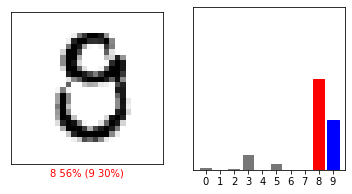

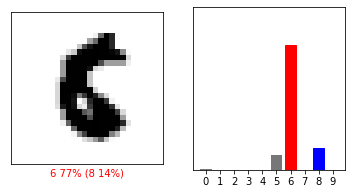

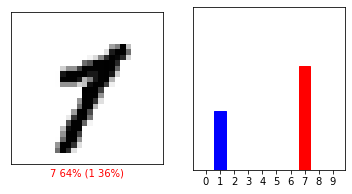

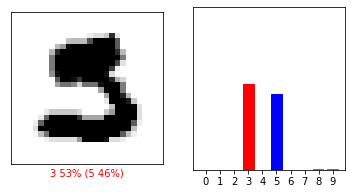

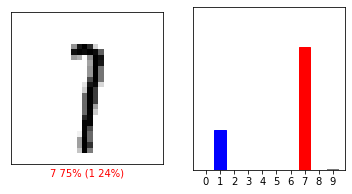

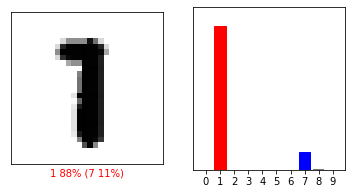

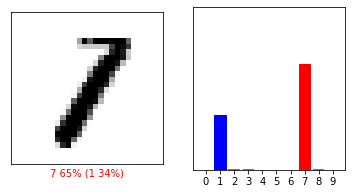

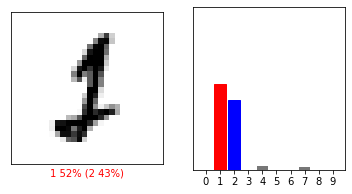

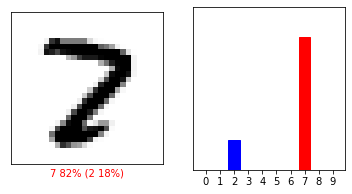

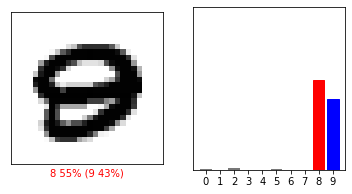

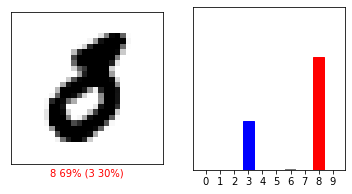

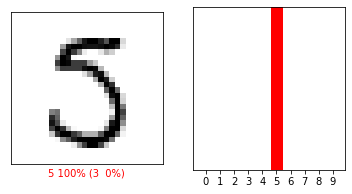

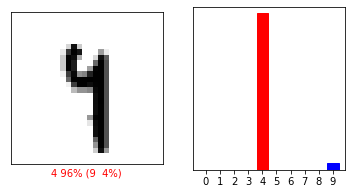

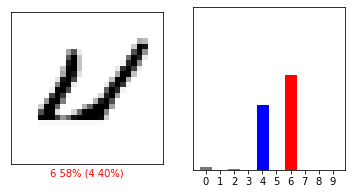

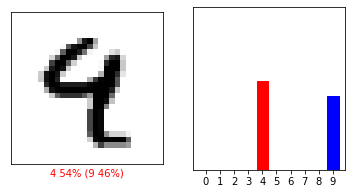

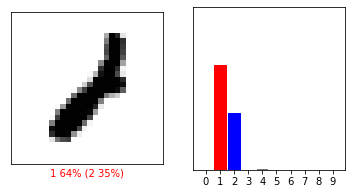

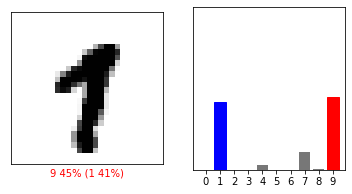

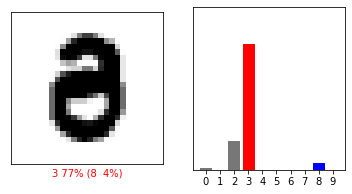

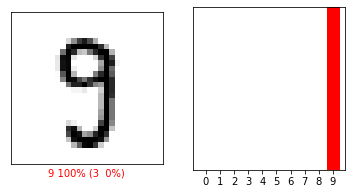

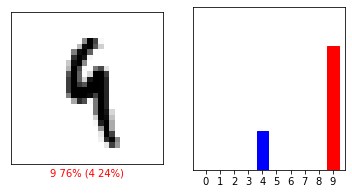

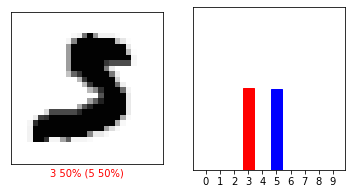

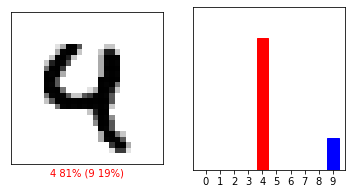

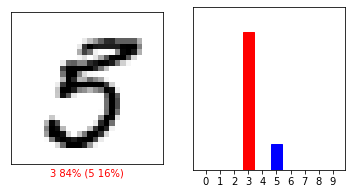

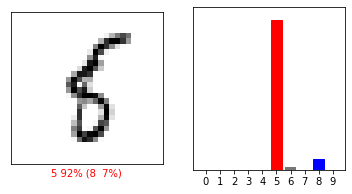

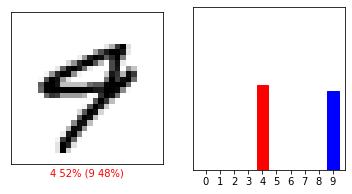

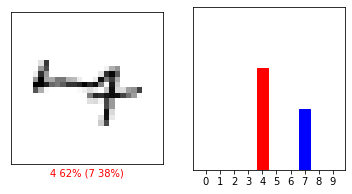

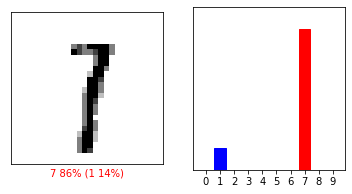

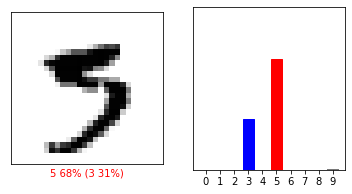

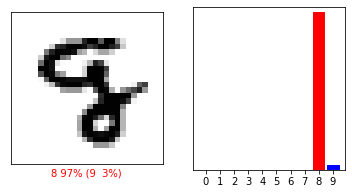

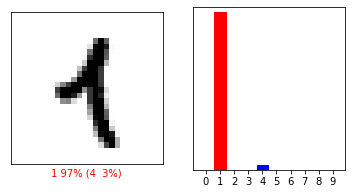

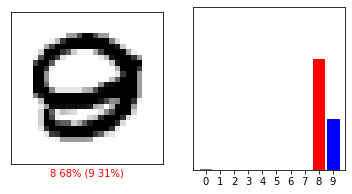

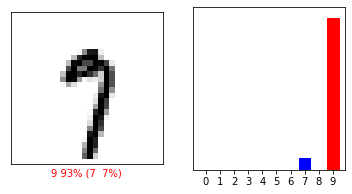

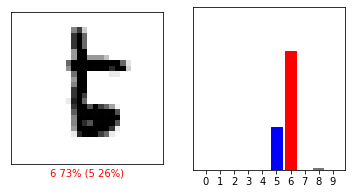

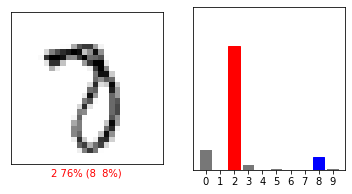

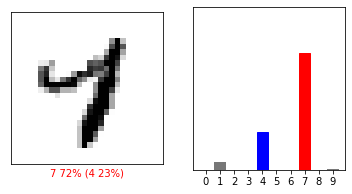

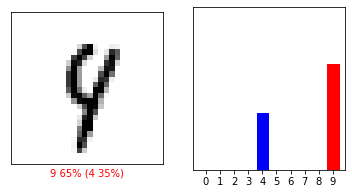

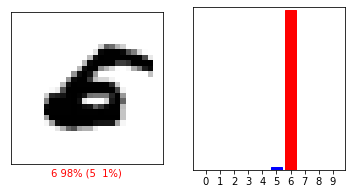

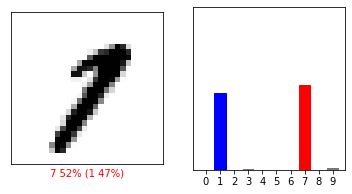

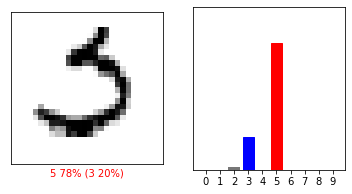

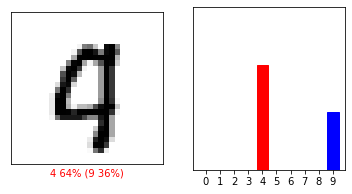

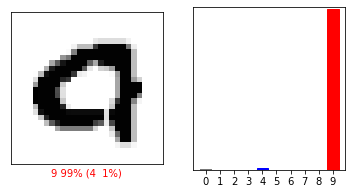

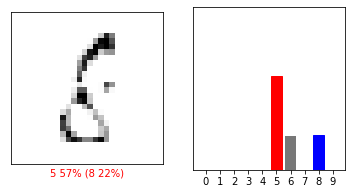

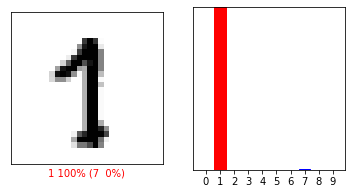

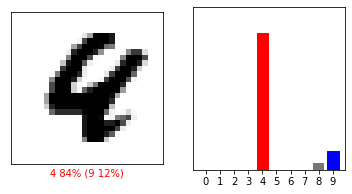

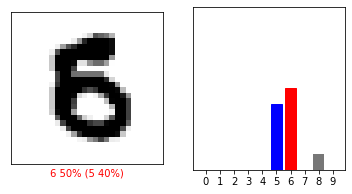

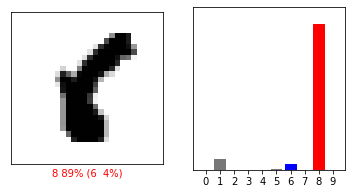

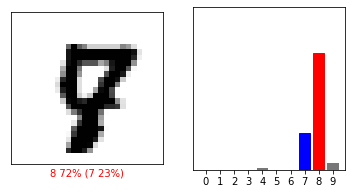

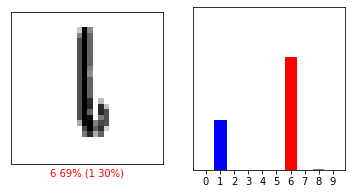

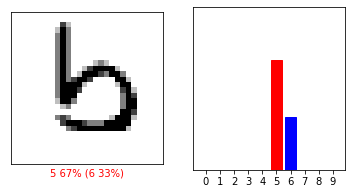

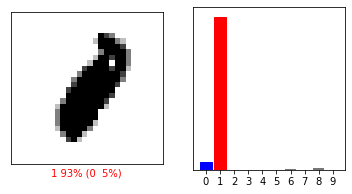

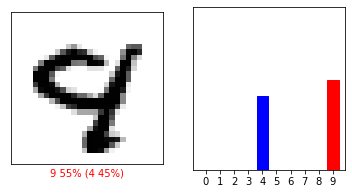

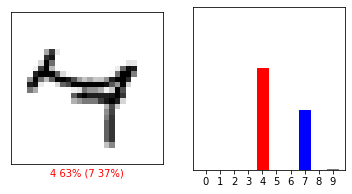

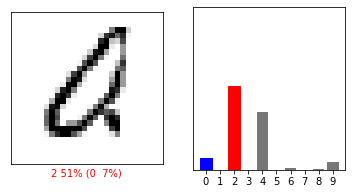

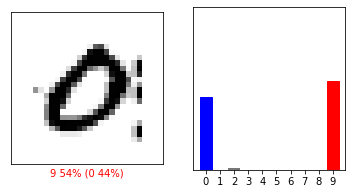

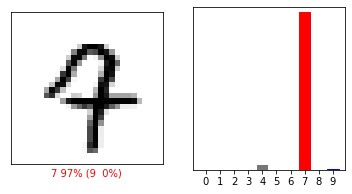

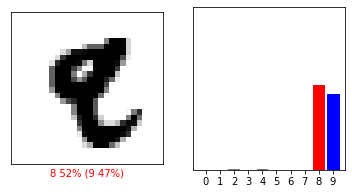

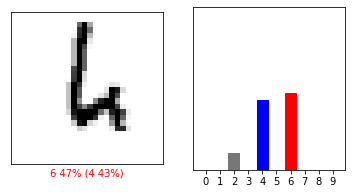

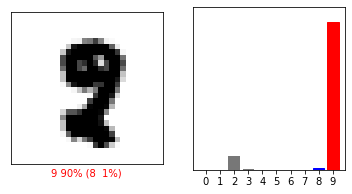

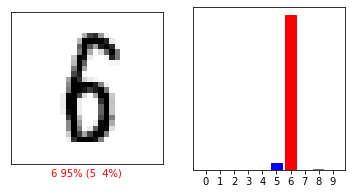

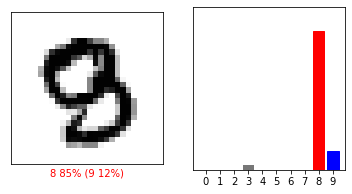

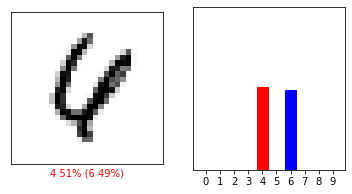

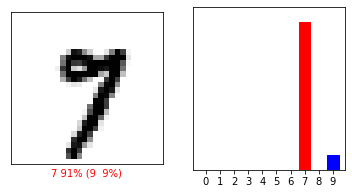

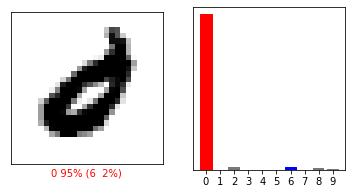

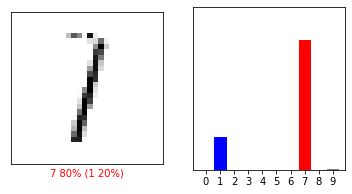

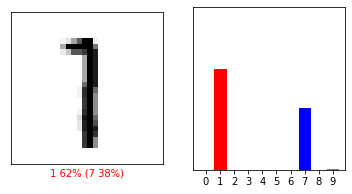

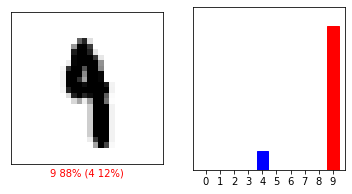

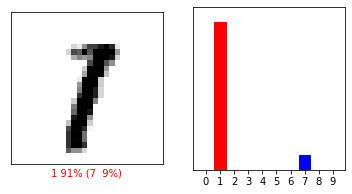

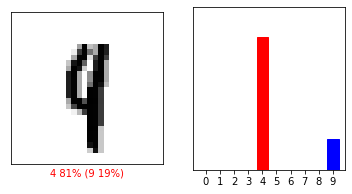

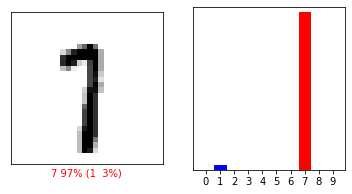

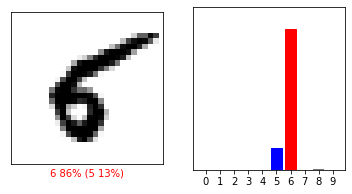

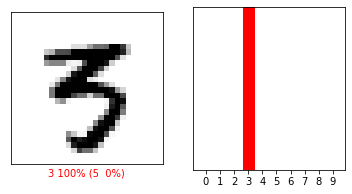

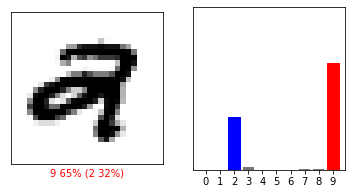

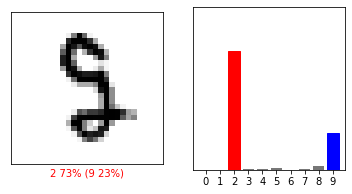

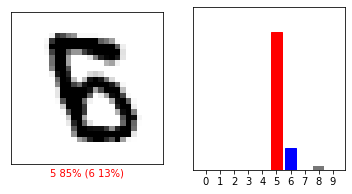

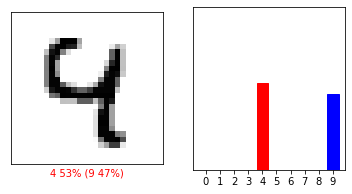

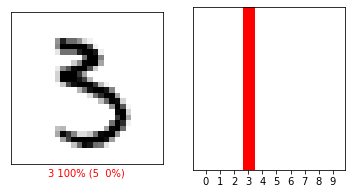

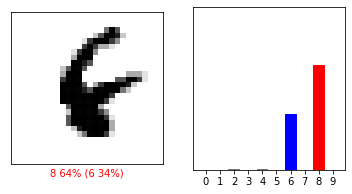

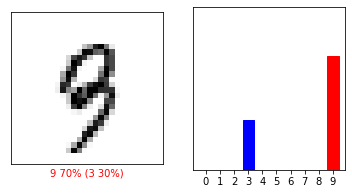

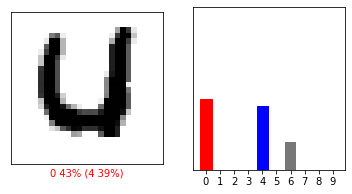

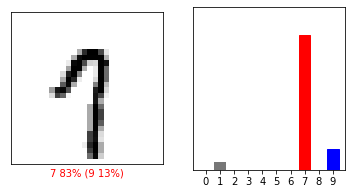

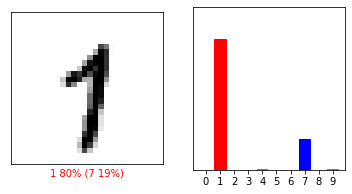

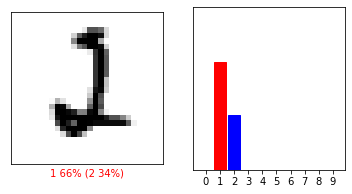

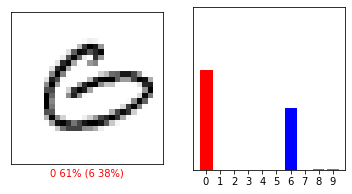

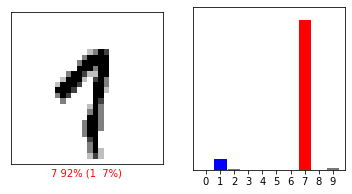

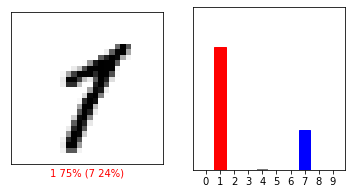

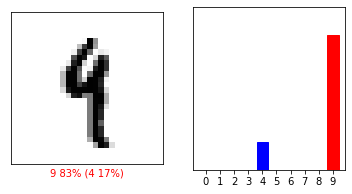

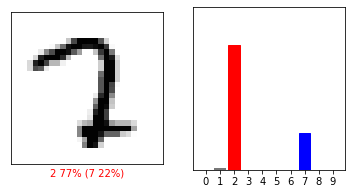

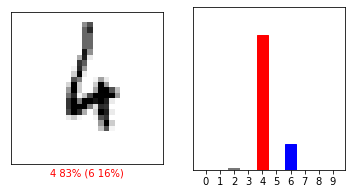

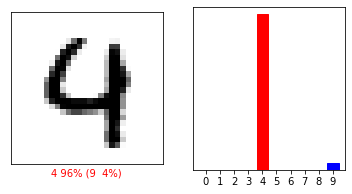

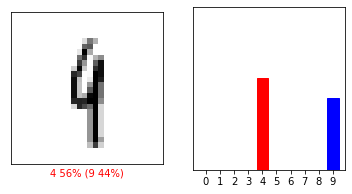

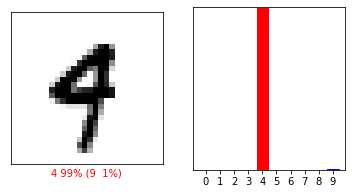

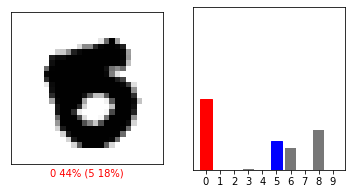

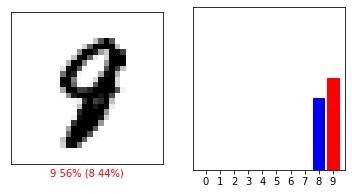

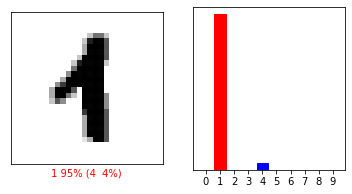

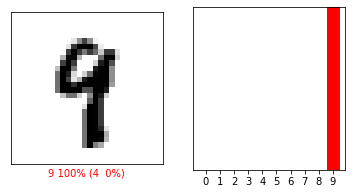

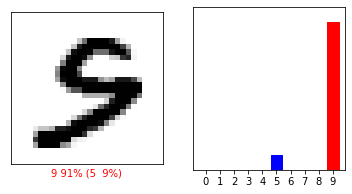

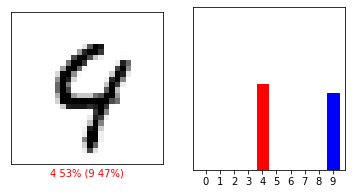

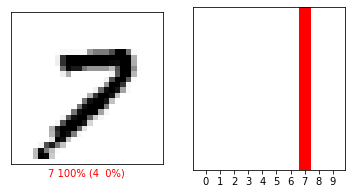

In [24]:
show_errors(tf_model, x_train, y_train)

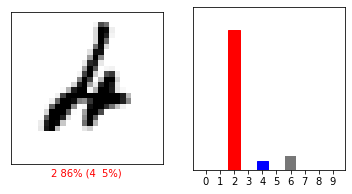

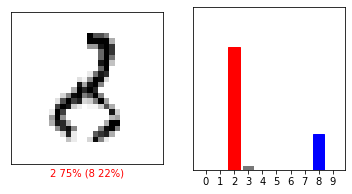

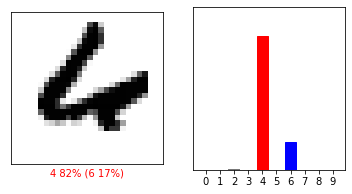

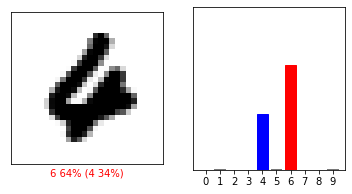

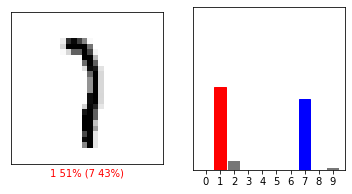

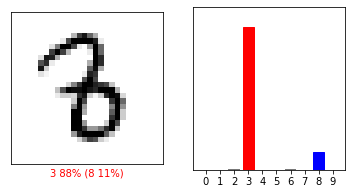

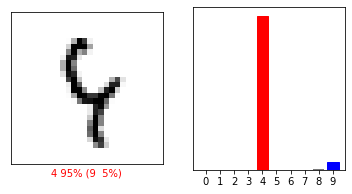

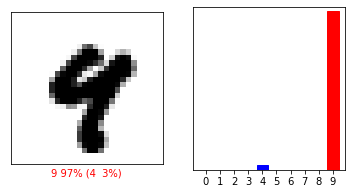

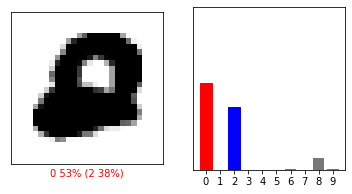

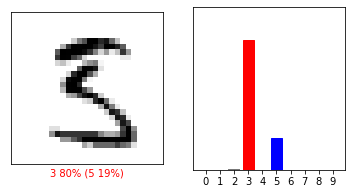

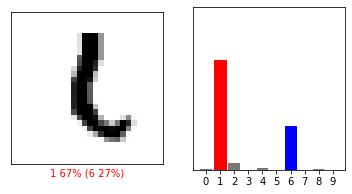

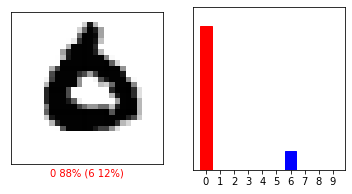

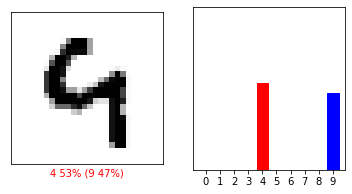

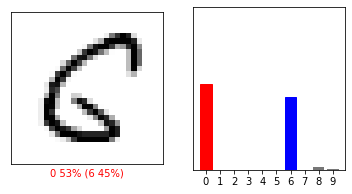

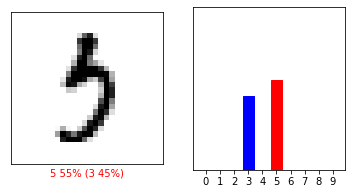

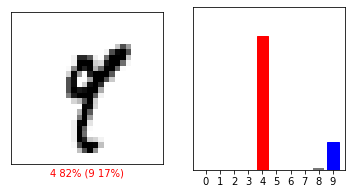

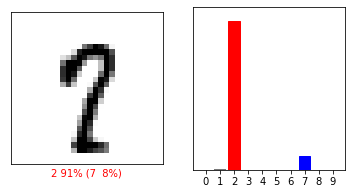

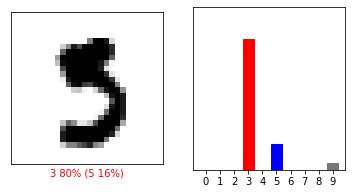

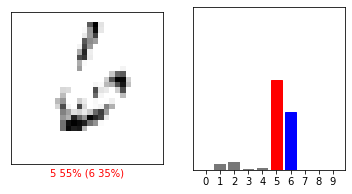

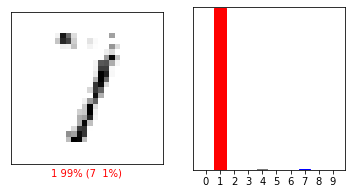

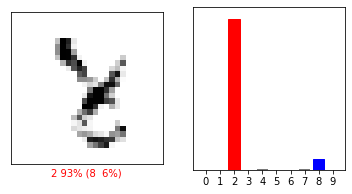

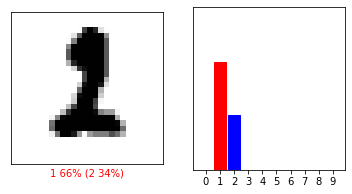

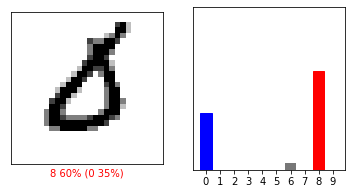

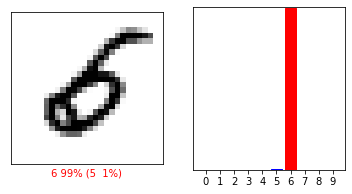

In [46]:
show_errors(tf_model, x_test, y_test)